## **Dataset**

In [9]:
!gdown 1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU
!unzip cvpr2016_flowers.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/cvpr2016_flowers/images/image_06706.jpg  
  inflating: content/cvpr2016_flowers/images/image_02041.jpg  
  inflating: content/cvpr2016_flowers/images/image_06550.jpg  
  inflating: content/cvpr2016_flowers/images/image_00556.jpg  
  inflating: content/cvpr2016_flowers/images/image_05695.jpg  
  inflating: content/cvpr2016_flowers/images/image_02732.jpg  
  inflating: content/cvpr2016_flowers/images/image_00112.jpg  
  inflating: content/cvpr2016_flowers/images/image_03424.jpg  
  inflating: content/cvpr2016_flowers/images/image_03702.jpg  
  inflating: content/cvpr2016_flowers/images/image_01316.jpg  
  inflating: content/cvpr2016_flowers/images/image_03391.jpg  
  inflating: content/cvpr2016_flowers/images/image_02503.jpg  
  inflating: content/cvpr2016_flowers/images/image_05044.jpg  
  inflating: content/cvpr2016_flowers/images/image_01633.jpg  
  inflating: content/cvpr2016_flowers/images/image_05305.jpg  
  in

In [10]:
import os

def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_name = image_file.split('.')[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()
        if image_name not in captions:
                captions[image_name] = caption
    return captions

In [11]:
captions_folder = "./content/cvpr2016_flowers/captions"
image_folder = "./content/cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)

## **Caption Encoder**

In [ ]:
import torch # type: ignore
import numpy as np # type: ignore
from sentence_transformers import SentenceTransformer # type: ignore

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            'embed': torch.tensor(bert_model.encode(caption)),
            'text': caption
        }
    return encoded_captions

In [13]:
encoded_captions = encode_captions(captions)

## **Preprocessing**

In [ ]:
from PIL import Image # type: ignore
from torch.utils.data import Dataset # type: ignore

class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load captions
        self.captions = captions

        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        encoded_caption = self.captions[img_name]['embed']
        caption = self.captions[img_name]['text']

        return {
            'image': image,
            'embed_caption': encoded_caption,
            'text': caption
        }

In [ ]:
import torchvision.transforms as transforms # type: ignore

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="./content/cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)

In [ ]:
import matplotlib.pyplot as plt # type: ignore

def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

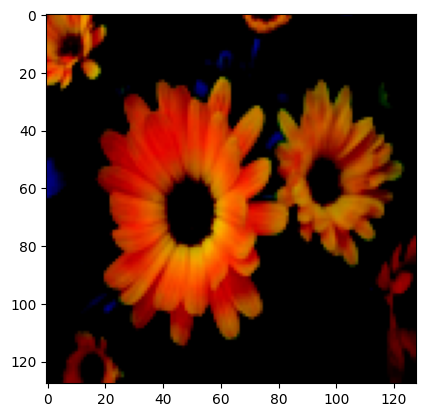

In [19]:
show_grid(next(iter(ds))['image'])

In [ ]:
from torch.utils.data import DataLoader # type: ignore

BATCH_SIZE = 64  #1024
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [54]:
batch_sample = next(iter(dataloader))

In [ ]:
# import torchvision

# show_grid(torchvision.utils.make_grid(batch_sample['image'], normalize=True))

## **Model**

In [ ]:
import torch.nn as nn # type: ignore

class Generator(nn.Module):

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        # Define the layers of the generator here.
        # Example:
        self.fc1 = nn.Linear(noise_size + reduced_dim_size, feature_size * 8 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(feature_size * 8, feature_size * 4, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(feature_size * 4)
        self.conv2 = nn.ConvTranspose2d(feature_size * 4, feature_size * 2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(feature_size * 2)
        self.conv3 = nn.ConvTranspose2d(feature_size * 2, feature_size, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(feature_size)
        self.conv4 = nn.ConvTranspose2d(feature_size, num_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.embedding_reduction = nn.Linear(embedding_size, reduced_dim_size)

    def forward(self, noise, embedding):
        # Reduce embedding dimensionality
        reduced_embedding = self.embedding_reduction(embedding)

        # Concatenate noise and embedding
        x = torch.cat([noise, reduced_embedding], dim=1)

        # Pass through the layers
        x = self.fc1(x)
        x = x.view(-1, 128 * 8, 4, 4) # Reshape to 4D for ConvTranspose2d
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.tanh(self.conv4(x)) # Output layer with tanh activation

        return x

In [56]:
generator = Generator(100, 128, 3, 768, 256).to(device)

In [84]:
class Discriminator(nn.Module):

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        # Define the layers of the discriminator here.
        # Example:
        self.imageEncoder = nn.Sequential(
            # 3 -> 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 -> 128
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 -> 256
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 -> 512
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 -> 1024
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.finalBlock = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input_img, text_embeddings):
        image_encoded = self.imageEncoder(input_img)

        text_encoded = self.textEncoder(text_embeddings)
        text_encoded = text_encoded.unsqueeze(1).unsqueeze(2)

        replicated_text = text_encoded.repeat(4, 4, 1, 1, 1).permute(2, 3, 0, 1)
        concat_layer = torch.cat([image_encoded, replicated_text], dim=1)
        x = self.finalBlock(concat_layer)

        return x.view(-1, 1), image_encoded

In [85]:
discriminator = Discriminator(3, 128, 768, 256).to(device)

## **Training**

In [86]:
bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [87]:
plt_o_text_embeddings = ds[0]['embed_caption'].unsqueeze(0)
plt_o_text_embeddings.shape

torch.Size([1, 768])

In [88]:
fixed_noise = torch.randn(size=(1, 100))
fixed_noise.shape

torch.Size([1, 100])

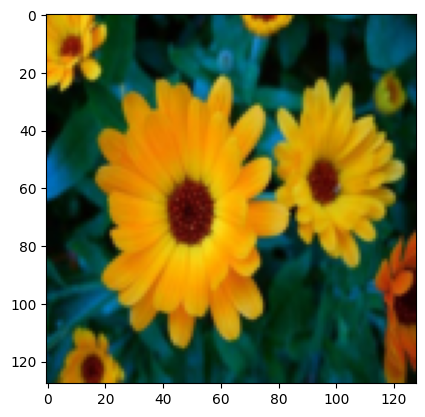

In [ ]:
import torchvision # type: ignore

show_grid(torchvision.utils.make_grid(ds[0]['image'], normalize=True))

In [90]:
def plot_output(generator):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [ ]:
import torch.optim as optim # type: ignore

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

In [ ]:
import time

epochs = 10

for epoch in range(epochs):

    d_losses, g_losses = [], []

    epoch_time = time.time()

    for batch in dataloader:
        images = batch['image'].to(device)
        text_embeddings = batch['embed_caption'].to(device)

        # Train the discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        real_outputs = discriminator(images, text_embeddings)
        d_loss_real = bce_loss(real_outputs, real_labels)

        noise = torch.randn(size=(images.size(0), 100)).to(device)
        fake_images = generator(noise, text_embeddings)
        fake_outputs = discriminator(fake_images.detach(), text_embeddings)
        d_loss_fake = bce_loss(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss.item())
        d_loss.backward()
        optimizer_D.step()

        ### Your Code Here

    avg_d_loss = sum(d_losses)/len(d_losses)
    avg_g_loss = sum(g_losses)/len(g_losses)

    if (epoch+1) % 10 == 0:
        plot_output(generator)


    print('Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, epochs,
        avg_d_loss,
        avg_g_loss,
        time.time() - epoch_time)
    )

## **Prediction**

In [ ]:
generator.eval()

noise = torch.randn(size=(1, 100))
text_embedding = ds[10]['embed_caption'].unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))
grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
show_grid(grid)

In [ ]:
import torch # type: ignore

# Save generator
torch.save(generator.state_dict(), 'generator.pth')

# Save discriminator
torch.save(discriminator.state_dict(), 'discriminator.pth')